In [1]:
#%matplotlib widget
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

import scipy as scp
import numpy as np
import time
import datetime
#from datetime import timedelta
import matplotlib.pyplot as plt

print("libraries imported")

libraries imported


In [253]:
# close plots
for i in range(1000):
    plt.close(i)

In [2]:
def getTime(mode):
    global start_time0, start_time, end_time0, end_time
    match mode:
        case 'integrateStart':
            start_time0 = time.time()
            start_time = datetime.datetime.fromtimestamp(start_time0)
            return start_time
        case 'integrateEnd':
            end_time0 = time.time()
            end_time = datetime.datetime.fromtimestamp(end_time0)
            return end_time
        case 'current':
            current_time0 = time.time()
            current_time = datetime.datetime.fromtimestamp(current_time0)
            return current_time0, current_time
def printAlligned(message, variable, unit, msgspaces=20, varspaces=30):
    output = print("{:{msgspace}s}= {:{varspace}s} {}".format(message, str(variable), unit, msgspace=msgspaces, varspace=varspaces))
    return output
def debug(level='partial'):
    match level:
        case 'partial':
            print('   DEBUG LEVEL PARTIAL')
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'full':
            print('   DEBUG LEVEL FULL')
            print("List of globals:")
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'constants':
            print('   DEBUG LEVEL CONSTANTS')
            localT = getTime('current')[1]
            printAlligned('Current time', localT, '')
        case 'start':
            print('   DEBUG LEVEL START')
            localT = getTime('integrateStart')
            printAlligned('Start time', localT, 'seconds', msgspaces=15)
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'end':
            print('   DEBUG LEVEL END')
            end_time = time.time()
            printAlligned('end_time',end_time, 'seconds', msgspaces=15)
            printAlligned('Wall runtime',end_time-start_time, msgspaces=15)
        case 'none':
            return None

def initialize(mode,inSpos=[0,0],inSvel=[0,0],startdebugmode='start'): 
    # Constants
    match mode:
        case 'constants':
            global ConstantsList, GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
            GravConst = 6.6726e-11
            dEM = 3.844e8                                     #Earth-Moon separation
            mE = 5.9742e24                                  #Earth Mass
            mM = 7.35e22                                    #Moon mass
            mT = mE + mM                                    #Barycentre mass
            rE = dEM*mM/mT                                    #Barycentre-Earth separation
            rM = dEM*mE/mT                                    #Barycentre-Moon separation
            PeriodEM = np.sqrt(4 * np.pi**2 * dEM**3 / GravConst / mT)    #Orbital period
            l2Original = rM + dEM*(mM/3/mE)**(1/3)
            l2VelOriginal = 2*np.pi * l2Original / PeriodEM
            drOriginal = dEM*(mM/3/mE)**(1/3)
            ConstantsList = [GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal]
            return None
        case 'inputs':
            global iniSpos, iniSvel
            iniSpos = np.array(inSpos)
            iniSvel = np.array(inSvel)
            debug(startdebugmode)
            return None
    return 'FAILED TO INITIALIZE'
##initial velocity ???
initialize('constants')


'''unused debug
print(start_time)
printAlligned('S position',Spos)
print("{:20s}= {}".format('S position',Spos))
print("S velocity     = {}".format(Svel))
print("S acceleration = {}".format(Sacc))
print("P = {}".format(P))
print("HR P = {}".format(timedelta(seconds = P)))
'''

def calcEpos(time, dim=2, constantsList=[]):
    # GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
    loc_rE = constantsList[5]
    loc_PeriodEM = constantsList[7]
    match dim:
        case 2:
            output = np.array([-loc_rE*np.cos(2*np.pi * time/loc_PeriodEM),-loc_rE*np.sin(2*np.pi * time/loc_PeriodEM)])
            return output
        case 3:
            output = np.array([-loc_rE*np.cos(2*np.pi * time/loc_PeriodEM),-loc_rE*np.sin(2*np.pi * time/loc_PeriodEM),0])
            return output
        case _:
            print('ERROR: UNKNOWN DIMENSION')
            return None
def calcMpos(time, dim=2, constantsList=[]):
    #GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
    loc_rM = constantsList[6]
    loc_PeriodEM = constantsList[7]
    match dim:
        case 2:
            output = np.array([loc_rM*np.cos(2*np.pi * time/loc_PeriodEM),loc_rM*np.sin(2*np.pi * time/loc_PeriodEM)])
            return output
        case 3:
            output = np.array([loc_rM*np.cos(2*np.pi * time/loc_PeriodEM),loc_rM*np.sin(2*np.pi * time/loc_PeriodEM),0])
            return output
        case _:
            print('ERROR: UNKNOWN DIMENSION')
            return None
def d2t_r(time, inPos, constantsList=[]):
    # GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
    dim = len(inPos)
    loc_GravConst= constantsList[0]
    loc_mE = constantsList[2]
    loc_mM = constantsList[3]
    Mpos = calcMpos(time, dim, constantsList)
    Epos = calcEpos(time, dim, constantsList)
    SumE = 0
    SumM = 0
    for i in range(dim):
        SumE = SumE + (inPos[i] - Epos[i])**2
        SumM = SumM + (inPos[i] - Mpos[i])**2
    dE = np.sqrt(SumE)
    dM = np.sqrt(SumM)
    Sacc = []
    for i in range(dim):
        Sacc.append(-loc_GravConst*loc_mE*(inPos[i] - Epos[i])/dE**3 - loc_GravConst*loc_mM*(inPos[i] - Mpos[i])/dM**3)
    Sacc = np.array(Sacc)
    return Sacc
''' old 2d code and unneeded match cases
    match dim:
        case 2:
            loc_mE = mE
            loc_mM = mM
            Mpos = calcMpos(time, 2)
            Epos = calcEpos(time, 2)
            SumE = 0
            dE = np.sqrt((x - Epos[0])**2 + (y - Epos[1])**2)
            dM = np.sqrt((x - Mpos[0])**2 + (y - Mpos[1])**2)
            x2 = -GravConst*loc_mE*(x - Epos[0])/dE**3 - GravConst*loc_mM*(x - Mpos[0])/dM**3
            y2 = -GravConst*loc_mE*(y - Epos[1])/dE**3 - GravConst*loc_mM*(y - Mpos[1])/dM**3
            Sacc = np.array([x2,y2])
            return Sacc
        case 3:
            loc_mE = mE
            loc_mM = mM
'''

' old 2d code and unneeded match cases\n    match dim:\n        case 2:\n            loc_mE = mE\n            loc_mM = mM\n            Mpos = calcMpos(time, 2)\n            Epos = calcEpos(time, 2)\n            SumE = 0\n            dE = np.sqrt((x - Epos[0])**2 + (y - Epos[1])**2)\n            dM = np.sqrt((x - Mpos[0])**2 + (y - Mpos[1])**2)\n            x2 = -GravConst*loc_mE*(x - Epos[0])/dE**3 - GravConst*loc_mM*(x - Mpos[0])/dM**3\n            y2 = -GravConst*loc_mE*(y - Epos[1])/dE**3 - GravConst*loc_mM*(y - Mpos[1])/dM**3\n            Sacc = np.array([x2,y2])\n            return Sacc\n        case 3:\n            loc_mE = mE\n            loc_mM = mM\n'

Main function definitions

In [3]:
def TaylorODEsolve3BP(mode, t_0, t_f, dt, limits=[0,0], progress=True):
    LocalConstantsList = ConstantsList
    match mode:
        case 'solve':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0, 2, LocalConstantsList)
            MposList[0] = calcMpos(t_0, 2, LocalConstantsList)
            for i in range(steps):
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                Sacc = d2t_r(t, Spos, LocalConstantsList)
                Spos = Spos + dt * Svel + Sacc * dt**2 / 2
                Svel = Svel + dt * Sacc
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t, 2, LocalConstantsList)
                MposList[i+1] = calcMpos(t, 2, LocalConstantsList)

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList
        case 'limits':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0, 2, LocalConstantsList)
            MposList[0] = calcMpos(t_0, 2, LocalConstantsList)
            for i in range(steps):
                '''#Progress bar, not used
                if i% (int(steps/10)) == 0:
                    n = round(i / steps, 2) * 100
                    printAlligned('{}%'.format(n), Spos,'m')
                    printAlligned('{}%'.format(n), Svel,'m s^-1')
                '''
                
                Sacc = d2t_r(t, Spos, LocalConstantsList)
                Spos = Spos + dt * Svel + Sacc * dt**2 / 2
                Svel = Svel + dt * Sacc
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t, 2, LocalConstantsList)
                MposList[i+1] = calcMpos(t, 2, LocalConstantsList)

                Sdist = np.sqrt(Spos[0]**2 + Spos[1]**2)
                if Sdist < limits[0]:
                    move = 1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
                if Sdist > limits[1]:
                    move = -1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            move = 0
            return SposList, MposList, EposList, tList, move, steps

def RK4ODEsolve3BP(mode, t_0, t_f, dt, limits=[0,0], progress=True): #t_0: time initial [seconds], t_f: time final [seconds], dt: time step
    LocalConstantsList = ConstantsList
    match mode:
        case 'solve':
            # GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0, 2, LocalConstantsList)
            MposList[0] = calcMpos(t_0, 2, LocalConstantsList)
            for i in range(steps):
                w0 = d2t_r(t, Spos, LocalConstantsList)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, u1, LocalConstantsList)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, u2, LocalConstantsList)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, u3, LocalConstantsList)
                
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t, 2, LocalConstantsList)
                MposList[i+1] = calcMpos(t, 2, LocalConstantsList)

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList
        case 'limits':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0, 2, LocalConstantsList)
            MposList[0] = calcMpos(t_0, 2, LocalConstantsList)
            for i in range(steps):
                w0 = d2t_r(t, Spos, LocalConstantsList)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, u1, LocalConstantsList)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, u2, LocalConstantsList)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, u3, LocalConstantsList)
                
                '''#progress bar, not in use
                if i% (int(steps/10)) == 0:
                    n = round(i / steps, 2) * 100
                    printAlligned('{}%'.format(n), Spos,'m')
                    printAlligned('{}%'.format(n), Svel,'m s^-1')
                '''
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                Sdist = np.sqrt(Spos[0]**2 + Spos[1]**2)
                
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t, 2, LocalConstantsList)
                MposList[i+1] = calcMpos(t, 2, LocalConstantsList)
                if Sdist < limits[0]:
                    move = 1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
                if Sdist > limits[1]:
                    move = -1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            move = 0
            return SposList, MposList, EposList, tList, move, steps
        case '3dSolve':

            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 3))
            EposList = np.zeros((steps + 1, 3))
            MposList = np.zeros((steps + 1, 3))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0, 3, LocalConstantsList)
            MposList[0] = calcMpos(t_0, 3, LocalConstantsList)
            for i in range(steps):
                w0 = d2t_r(t, Spos, LocalConstantsList)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, u1, LocalConstantsList)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, u2, LocalConstantsList)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, u3, LocalConstantsList)
                
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t, 3, LocalConstantsList)
                MposList[i+1] = calcMpos(t, 3, LocalConstantsList)

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList

def test(mode, t_0, t_f,dt, progress=True):
    match mode:
        case '3dSolve':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 3))
            EposList = np.zeros((steps + 1, 3))
            MposList = np.zeros((steps + 1, 3))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                w0 = d2t_r(t, Spos)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, u1)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, u2)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, u3)
                
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList

def plot(data=None,label='',mode='plot', plotLims=[-5e8,5e8,-5e8,5e8]):
    global ax
    match mode:
        case 'plot':
            ax.plot(*data, label=label)
        case 'axes':
            ax = plt.figure().add_subplot()
            plotLims = ax.axis(plotLims)
            ax.set_aspect('equal',adjustable='box')
            print('plot limits:{}'.format(plotLims))
            plt.axhline(0, color='black')
            plt.axvline(0, color='black')
        case 'show':
            ax.legend()
            plt.show()
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
    x_limits = np.array(x_limits)
    y_limits = np.array(y_limits)
    z_limits = np.array(z_limits)
    print('x limits: {}'.format(x_limits))
    print('y limits: {}'.format(y_limits))
    print('z limits: {}'.format(z_limits))
    x_exponents = max(getSignedExponent(x_limits))
    y_exponents = max(getSignedExponent(y_limits))
    z_exponents = max(getSignedExponent(z_limits))
    return [x_exponents, y_exponents, z_exponents]
    
def getSignedExponent(inputNumber):
    return np.floor(np.log10(np.abs(inputNumber)))

print(np.floor(np.log10(np.array([1.5,2.5]))))

def findFFactor(mode, fGuess, dPlaces, tolerance = 1e6, t_f = PeriodEM):
    fGuessStr = str(fGuess)
    print('guess: {}'.format('.' in fGuessStr))
    if ('.' in fGuessStr):
        dPlace = len(fGuessStr.split('.')[1])
    else:
        dPlace = 0
    f = fGuess
    fo = f
    #find length of decimal part
    digit = 0
    n = 1 #factor finding iteration number
    flist = []
    flist.append(f)
    pointslist = []
    match mode:
        case 'RK4':
            while dPlace <= dPlaces:
                dr = drOriginal *f
                l2 = rM + dr
                l2Vel = 2*np.pi * l2 / PeriodEM
                limits = [l2 - tolerance, l2 + tolerance]
                initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
                out = RK4ODEsolve3BP('limits', 0, t_f, 100, limits= limits) #solve in limit mode
                
                move = out[4]
                steps = out[5]
                if move == 1:
                    digit+=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}'.format('move:', str(move), 'steps:',steps))
                elif move == -1:
                    digit-=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    dPlace+=1
                    digit = 0
                    fo = f
                elif move ==0:
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    break
                else:
                    print('ERROR')
                    break
                flist.append(f)
                n+=1
        case 'Taylor':
            while dPlace <= dPlaces:
                dr = drOriginal *f
                l2 = rM + dr
                l2Vel = 2*np.pi * l2 / PeriodEM
                limits = [l2 - tolerance, l2 + tolerance]
                initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
                out = TaylorODEsolve3BP('limits', 0, t_f, 10, limits= limits) #solve in limit mode
                pointslist = [out[i] for i in range(3)]
                move = out[4]
                steps = out[5]
                if move == 1:
                    digit+=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}'.format('move:', str(move), 'steps:',steps))
                elif move == -1:
                    digit-=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    dPlace+=1
                    digit = 0
                    fo = f
                elif move ==0:
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    break
                else:
                    print('ERROR')
                    break
                flist.append(f)
                n+=1
    dr = drOriginal *f
    l2 = rM + dr
    l2Vel = 2*np.pi * l2 / PeriodEM
    limits = [l2 - tolerance, l2 + tolerance]
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
    out = RK4ODEsolve3BP('limits', 0, t_f, 100, limits= limits)
    pointslist = [out[i] for i in range(4)]
    print('f={} in {} steps'.format(f,n))
    return f, n, flist, pointslist

[0. 0.]


3D Testing

In [230]:
fRK4    = 1.048615605975
dr = drOriginal *fRK4
l2 = rM + dr
l2vel = 2*np.pi * l2 / PeriodEM
initialize('inputs', [l2+2.5848769097e1,-2e2,0], [0,l2vel,4e-3])
SposList, MposList, EposList, tList = RK4ODEsolve3BP('3dSolve', 0, 2*PeriodEM, 100, progress=True)




   DEBUG LEVEL START
Start time     = 2023-12-07 15:02:40.718454     seconds
S position          = [ 4.44248382e+08 -2.00000000e+02  0.00000000e+00] m
S velocity          = [0.00000000e+00 1.18411376e+03 4.00000000e-03] m s^-1
0.0%                = [ 4.44248382e+08 -2.00000000e+02  0.00000000e+00] m
0.0%                = [0.00000000e+00 1.18411376e+03 4.00000000e-03] m s^-1
10.0%               = [1.37344535e+08 4.22484362e+08 6.56725089e+02] m
10.0%               = [-1.12610394e+03  3.66082983e+02 -2.49487190e-03] m s^-1
20.0%               = [-3.59324899e+08  2.61232244e+08 -8.19223098e+02] m
20.0%               = [-6.96296130e+02 -9.57755187e+02 -8.87822963e-04] m s^-1
30.0%               = [-3.59523904e+08 -2.60958077e+08  3.65196032e+02] m
30.0%               = [ 6.95566650e+02 -9.58286948e+02  3.60237106e-03] m s^-1
40.0%               = [ 1.37022834e+08 -4.22588858e+08  3.63662220e+02] m
40.0%               = [ 1.12638199e+03  3.65224695e+02 -3.60588403e-03] m s^-1
50.0%         

(47146, 3)
(3, 47146)
(3, 47146)
x limits: [-1266.96634448   138.81157889]
y limits: [-270.33736586  884.67306562]
z limits: [-840.17993464  840.17843553]
[3.0, 2.0, 2.0]


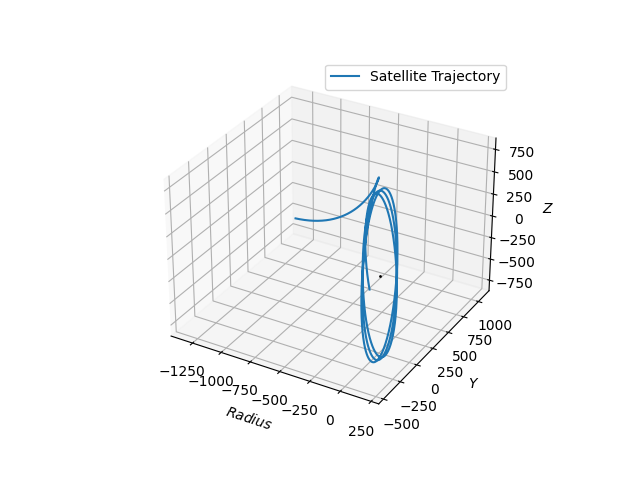

x limits: [-1273.37826602   276.97301663]
y limits: [-251.62016348  884.02343298]
z limits: [-840.17993464  840.17843553]
[3.0, 2.0, 2.0]


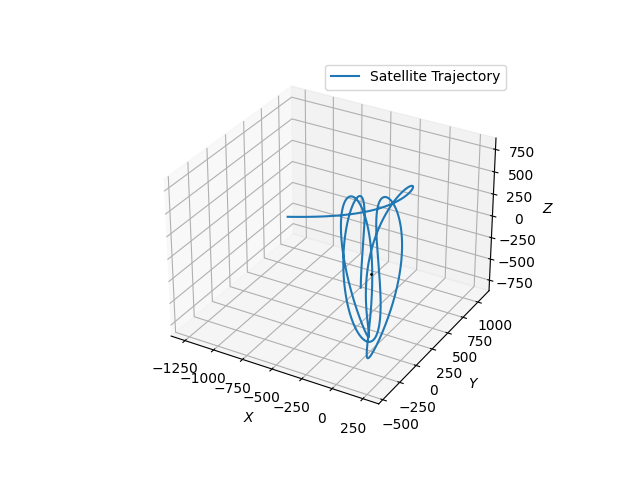

[1.14285715 1.14285715 0.85714286]
x limits: [-4.88673267e+08  4.88673253e+08]
y limits: [-4.88673144e+08  4.88673175e+08]
z limits: [-840.17993464  840.17843553]
[1.14285715 1.14285715 0.85714286]


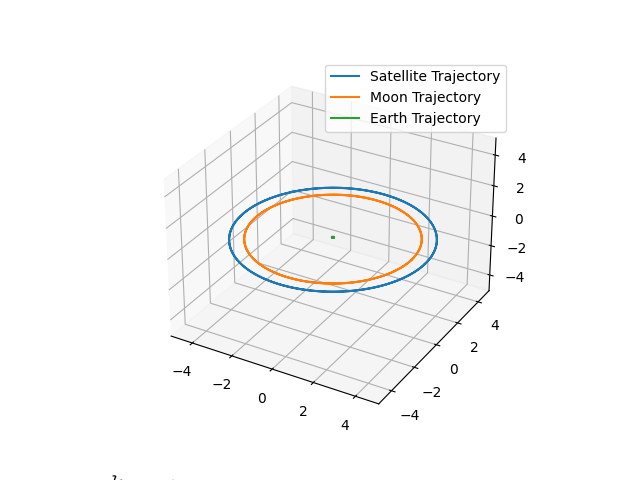

In [240]:
# close plots
for i in range(21):
    plt.close(i)

L2PosList = np.zeros(shape=(len(tList),3)) #Stopped to sleep here
L2PosList = np.array([[l2*np.cos(2*np.pi*tList[i]/PeriodEM),l2*np.sin(2*np.pi*tList[i]/PeriodEM),0] for i in range(len(tList))])
print(np.shape(L2PosList))
L2PosList = np.transpose(L2PosList)
print(np.shape(L2PosList))

L2FrameSposList = SposList - L2PosList
L2RotFrameSposList = np.array([np.cos(2*np.pi*tList/PeriodEM)*L2FrameSposList[0]+np.sin(2*np.pi*tList/PeriodEM)*L2FrameSposList[1],-np.sin(2*np.pi*tList/PeriodEM)*L2FrameSposList[0]+np.cos(2*np.pi*tList/PeriodEM)*L2FrameSposList[1],L2FrameSposList[2]])
print(np.shape(L2RotFrameSposList))
#output = np.array([-loc_rE*np.cos(2*np.pi * time/loc_PeriodEM),-loc_rE*np.sin(2*np.pi * time/loc_PeriodEM),0])
fig = plt.figure(1)
ax = fig.add_subplot(projection = '3d', proj_type = 'persp')
ax.plot(*L2RotFrameSposList, label='Satellite Trajectory')
ax.plot(0, 0, marker="o", markersize=1, markeredgecolor="black")
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)
ax.zaxis.get_offset_text().set_visible(False)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

expList = set_axes_equal(ax)
print(expList)
ax.legend()
plt.show()

fig = plt.figure(2)
ax = fig.add_subplot(projection = '3d', proj_type = 'persp')
ax.plot(*L2FrameSposList, label='Satellite Trajectory')
ax.plot(0, 0, marker="o", markersize=1, markeredgecolor="black")
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)
ax.zaxis.get_offset_text().set_visible(False)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

expList = set_axes_equal(ax)
print(expList)
ax.legend()
plt.show()

ax = plt.figure(3).add_subplot(projection='3d',proj_type='persp')
ax.plot(*SposList, label='Satellite Trajectory')
ax.plot(*MposList, label='Moon Trajectory')
ax.plot(*EposList, label='Earth Trajectory')
aspect = ax.get_box_aspect()
print(aspect)
ax.legend()
set_axes_equal(ax)
aspect = ax.get_box_aspect()
print(aspect)

plt.show()

### Axis equalization in 3D
Code courtesy of karlo at: https://stackoverflow.com/questions/13685386/how-to-set-the-equal-aspect-ratio-for-all-axes-x-y-z

In [ ]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Use this for matplotlib prior to 3.3.0 only.
#ax.set_aspect("equal'")
#
# Use this for matplotlib 3.3.0 and later.
# https://github.com/matplotlib/matplotlib/pull/17515
ax.set_box_aspect([1.0, 1.0, 1.0])

X = np.random.rand(100)*10+5
Y = np.random.rand(100)*10+2.5
Z = np.random.rand(100)*10+25

scat = ax.scatter(X, Y, Z)

set_axes_equal(ax)
plt.show()

[1.05624157 1.05624157 1.05624157]


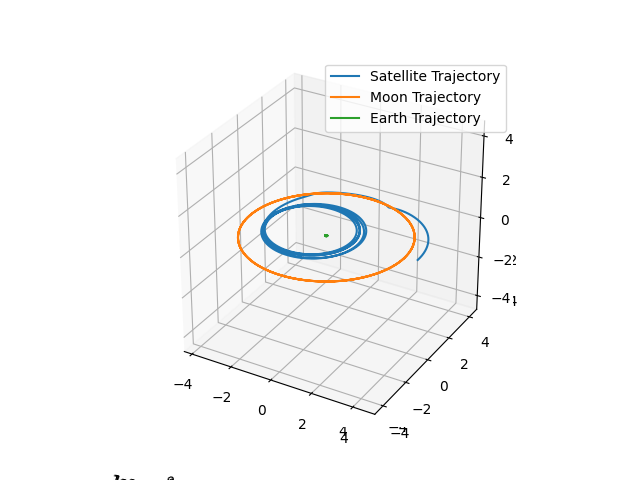

In [37]:
ax = plt.figure(1).add_subplot(projection='3d',proj_type='persp')
ax.set_aspect('equal')
ax.plot(*SposList, label='Satellite Trajectory')
ax.plot(*MposList, label='Moon Trajectory')
ax.plot(*EposList, label='Earth Trajectory')
aspect = ax.get_box_aspect()
print(aspect)
ax.legend()
set_axes_equal(ax)

plt.show()



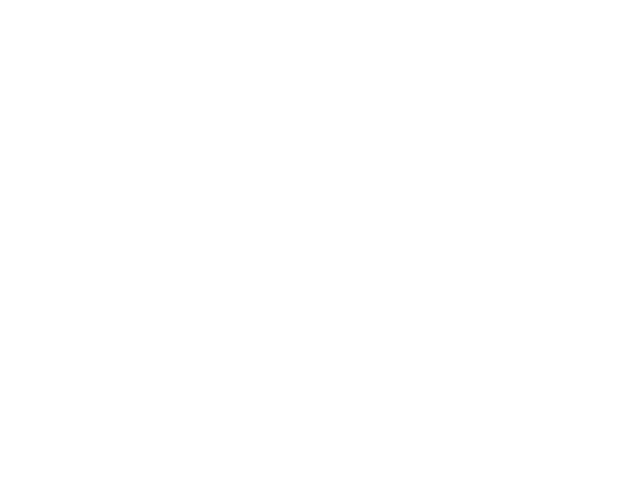

In [27]:
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)
plot1 = ax.scatter(*SposList, color='blue')
plot1 = ax.scatter(*EposList, color='green')
plot1 = ax.scatter(*MposList, color='red')
ax.set_title('Interactive plot of orbit')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_zlabel('z position')
plt.show()

In [ ]:
%matplotlib widget
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
 
# creating random dataset
xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
      44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]
 
ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
      5, 2, 4, 1, 8, 7, 0, 5]
 
zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
      3, 4, 5, 6, 7, 8, 9, 0]
 
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
 
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')
 
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
 
# displaying the plot
plt.show()

Full solve

   FULL SOLVE
Start time:         0s   End time:      2357285.9706s   Taylor timestep:     10s   RK4 timestep:       100s
L2 error vector naive:   (-5.493581e+02, -4.364474e+03) m
L2 error distance naive: 4.398912e+03 m
L2 error vector:   (-5.493018e+02, 2.705373e+03) m
L2 error distance: 2.760575e+03 m
Initial Moon-Satellite Separation: 64519610.196479075m
Final Moon-Satellite Separation:   64519060.90831959m
Error on dr:                       0.0006152885329576097m
plot limits:(-500000000.0, 500000000.0, -500000000.0, 500000000.0)


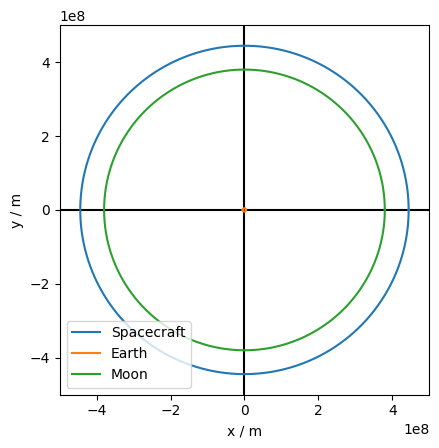

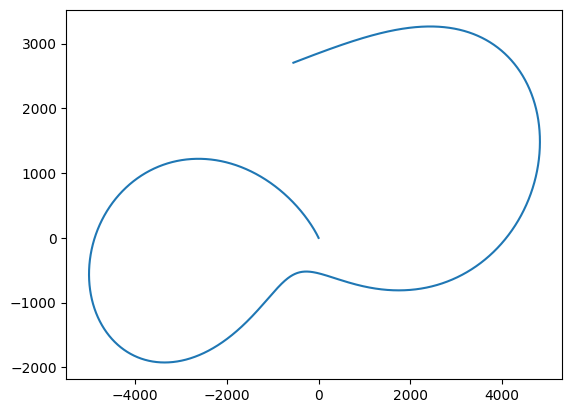

L2 error vector naive:   (-2.406803e+03, -1.002887e+05) m
L2 error distance naive: 1.003176e+05 m
L2 error vector:   (-2.395140e+03, 1.510278e+03) m
L2 error distance: 2.831543e+03 m
Initial Moon-Satellite Separation: 64520115.77906661m
Final Moon-Satellite Separation:   64517720.31086647m
Error on dr:                       0.0006152885329576098m
plot limits:(-500000000.0, 500000000.0, -500000000.0, 500000000.0)


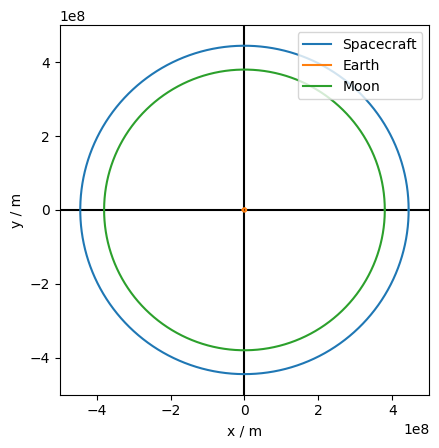

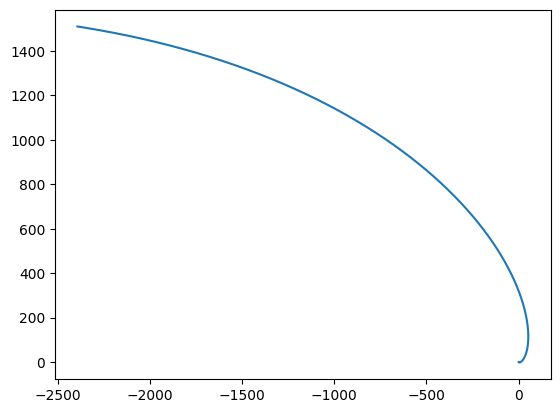

In [16]:
def full_solve(t_0, t_f, dtTaylor,dtRK4):
    print('   FULL SOLVE')
    print('{:11s}{:10}s   {:9s}{:18.4f}s   {:18s}{:5}s   {:18s}{:5}s'.format('Start time:', t_0, 'End time:', t_f, 'Taylor timestep:', dtTaylor,'RK4 timestep:',dtRK4))
    global fRK4, fTaylor
    fTaylor = 1.0486073889
    fRK4    = 1.0486156059
    #fRK4    = 1.048615605975
    
    #fRK4    = 1.04859279325 #NOT WORKING

    
    dr = drOriginal *fTaylor
    l2 = rM + dr
    l2vel = 2*np.pi * l2 / PeriodEM

    initialize('constants')
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2vel], startdebugmode='none')
    SposList, MposList, EposList, tList = TaylorODEsolve3BP('solve', t_0, t_f, dtTaylor, progress=False)
    
    L2PosList = np.array([l2*np.cos(2*np.pi*tList/PeriodEM),l2*np.sin(2*np.pi*tList/PeriodEM)])
    L2FrameSposList = SposList - L2PosList

    ManipulateSposList = np.transpose(SposList)
    errorVector = ManipulateSposList[-1] - ManipulateSposList[0]
    errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)

    errorVectorL2 = np.transpose(L2FrameSposList)[-1]
    errorDistL2 = np.sqrt(errorVectorL2[0]**2 + errorVectorL2[1]**2)

    ManipulateMposList = np.transpose(MposList)
    MSfinalSeparationVector = ManipulateMposList[-1] - ManipulateSposList[-1]
    MSfinalSeparationDist = np.sqrt(MSfinalSeparationVector[0]**2 + MSfinalSeparationVector[1]**2)
    print('L2 error vector naive:   ({:3e}, {:3e}) m'.format(*errorVector))
    print('L2 error distance naive: {:3e} m'.format(errorDist))
    print('L2 error vector:   ({:3e}, {:3e}) m'.format(*errorVectorL2))
    print('L2 error distance: {:3e} m'.format(errorDistL2))
    print('Initial Moon-Satellite Separation: {}m'.format(dr))
    print('Final Moon-Satellite Separation:   {}m'.format(MSfinalSeparationDist))
    print('Error on dr:                       {}m'.format(1e-11/fTaylor*dr))
    plot(mode='axes')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SposList,label='Spacecraft')
    plot(data=EposList,label='Earth')
    plot(data=MposList,label='Moon')
    plot(mode='show')

    plot1 = plt.figure()
    #L2FrameSposList = np.transpose(L2FrameSposList)
    ax = plot1.add_subplot()
    ax.plot(*L2FrameSposList)
    plt.show()
    '''
    SLunCoordPos = SposList - MposList
    ELunCoordPos = EposList - MposList
    plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SLunCoordPos, label='Spacecraft')
    plot(mode='show')
    '''

    #f = 1.04859279325
    #f  = 1.0486156059

    dr = drOriginal *fRK4
    l2 = rM + dr
    l2vel = 2*np.pi * l2 / PeriodEM

    initialize('constants')
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2vel], startdebugmode='none')
    SposList, MposList, EposList, tList = RK4ODEsolve3BP('solve', t_0, t_f, dtRK4, progress=False)

    L2PosList = np.array([l2*np.cos(2*np.pi*tList/PeriodEM),l2*np.sin(2*np.pi*tList/PeriodEM)])
    L2FrameSposList = SposList - L2PosList

    ManipulateSposList = np.transpose(SposList)
    errorVector = ManipulateSposList[-1] - ManipulateSposList[0]
    errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)

    errorVectorL2 = np.transpose(L2FrameSposList)[-1]
    errorDistL2 = np.sqrt(errorVectorL2[0]**2 + errorVectorL2[1]**2)
    ManipulateMposList = np.transpose(MposList)
    MSfinalSeparationVector = ManipulateMposList[-1] - ManipulateSposList[-1]
    MSfinalSeparationDist = np.sqrt(MSfinalSeparationVector[0]**2 + MSfinalSeparationVector[1]**2)
    print('L2 error vector naive:   ({:3e}, {:3e}) m'.format(*errorVector))
    print('L2 error distance naive: {:3e} m'.format(errorDist))
    print('L2 error vector:   ({:3e}, {:3e}) m'.format(*errorVectorL2))
    print('L2 error distance: {:3e} m'.format(errorDistL2))
    print('Initial Moon-Satellite Separation: {}m'.format(dr))
    print('Final Moon-Satellite Separation:   {}m'.format(MSfinalSeparationDist))
    print('Error on dr:                       {}m'.format(1e-11/fRK4*dr))

    plot(mode='axes')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SposList,label='Spacecraft')
    plot(data=EposList,label='Earth')
    plot(data=MposList,label='Moon')
    plot(mode='show')
    SLunCoordPos = SposList - MposList
    ELunCoordPos = EposList - MposList
    
    plot1 = plt.figure()
    #L2FrameSposList = np.transpose(L2FrameSposList)
    ax = plot1.add_subplot()
    ax.plot(*L2FrameSposList)
    plt.show()
    '''
    plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SLunCoordPos, label='Spacecraft')
    plot(mode='show')
    '''
    

full_solve(0, PeriodEM, 10, 100)

FFactor algorithm Taylor

In [ ]:
initialize('constants')
out = findFFactor('Taylor',1 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fTaylor = out[0]
out = findFFactor('Taylor',local_fTaylor, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fTaylor)

FFactor algorithm RK4

In [ ]:
initialize('constants')
out = findFFactor('RK4',1 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
out = findFFactor('RK4',local_fRK4, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)

Verification of FFactor

In [ ]:
fTaylor = 1.0486073889
fRK4    = 1.048615605975

initialize('constants')

out = findFFactor('RK4',fRK4 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
out = findFFactor('RK4',fRK4, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)

out = findFFactor('Taylor',fTaylor , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fTaylor = out[0]
out = findFFactor('Taylor',fTaylor, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fTaylor)

In [78]:
fRK4    = 1.048615605975

out = findFFactor('RK4',fRK4 , 12,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
out = findFFactor('RK4',fRK4, 12,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)

guess: True
move:      1  steps:         30056
move:     -1  steps:         31978  f:    1.048615605900  n:                 2
move:      1  steps:         30056
move:      1  steps:         30304
move:      1  steps:         30594
move:      1  steps:         30942
move:      1  steps:         31378
move:      1  steps:         31960
move:      1  steps:         32843
move:      1  steps:         34729
move:     -1  steps:         34803  f:    1.048615605970  n:                11
move:      1  steps:         34729
move:      1  steps:         35108
move:      1  steps:         35591
move:      1  steps:         36265
move:      1  steps:         37405
move:      1  steps:         41671
move:     -1  steps:         37791  f:    1.048615605975  n:                18
f=1.048615605975 in 19 steps
guess: True
move:      0  steps:         23572  f:    1.048615605900  n:                 1
f=1.0486156059 in 1 steps
True


In [5]:
x = np.zeros(shape=(4,3))
x[0] = [1,2,3]
print(x)

[[1. 2. 3.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
